<a href="https://colab.research.google.com/github/Wiz1102/AmazonReviews/blob/main/NLPFinal_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import nltk

import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import Word2Vec



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define a function to parse fastText format
def parse_fasttext_format(filepath):
    parsed_data = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            try:
                # Extract label and review
                label, review = line.split(' ', 1)
                # Convert label to numeric (1 for __label__1, 2 for __label__2)
                star_rating = 1 if '__label__1' in label else 2
                parsed_data.append({'review_body': review.strip(), 'star_rating': star_rating})
            except ValueError:
                # Skip malformed lines
                continue
    return pd.DataFrame(parsed_data)

# Process training and testing datasets
train_file = '/content/drive/MyDrive/AmazonReviewsData/train.ft.txt'  # Update with correct path
test_file = '/content/drive/MyDrive/AmazonReviewsData/test.ft.txt'   # Update with correct path

train_data = parse_fasttext_format(train_file)
test_data = parse_fasttext_format(test_file)

# Display parsed data
print("Training Data Sample:\n", train_data.head())
print("Testing Data Sample:\n", test_data.head())


Training Data Sample:
                                          review_body  star_rating
0  Stuning even for the non-gamer: This sound tra...            2
1  The best soundtrack ever to anything.: I'm rea...            2
2  Amazing!: This soundtrack is my favorite music...            2
3  Excellent Soundtrack: I truly like this soundt...            2
4  Remember, Pull Your Jaw Off The Floor After He...            2
Testing Data Sample:
                                          review_body  star_rating
0  Great CD: My lovely Pat has one of the GREAT v...            2
1  One of the best game music soundtracks - for a...            2
2  Batteries died within a year ...: I bought thi...            1
3  works fine, but Maha Energy is better: Check o...            2
4  Great for the non-audiophile: Reviewed quite a...            2


In [ ]:
# Check for missing values
print("Missing values in training data:\n", train_data.isnull().sum())
print("Missing values in testing data:\n", test_data.isnull().sum())

# Remove rows with missing or invalid values
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Check data shape after cleaning
print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)


Missing values in training data:
 review_body    0
star_rating    0
dtype: int64
Missing values in testing data:
 review_body    0
star_rating    0
dtype: int64
Training Data Shape: (3600000, 2)
Testing Data Shape: (400000, 2)


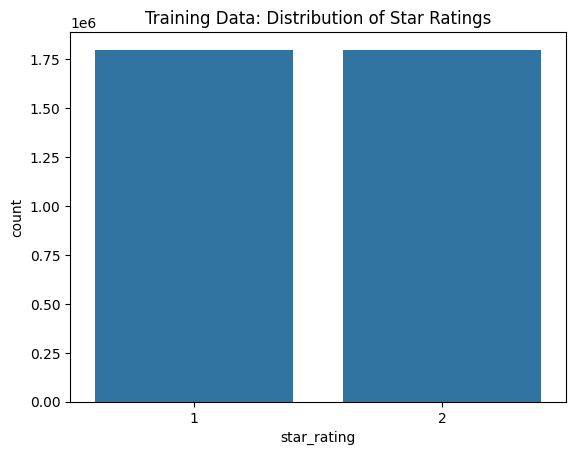

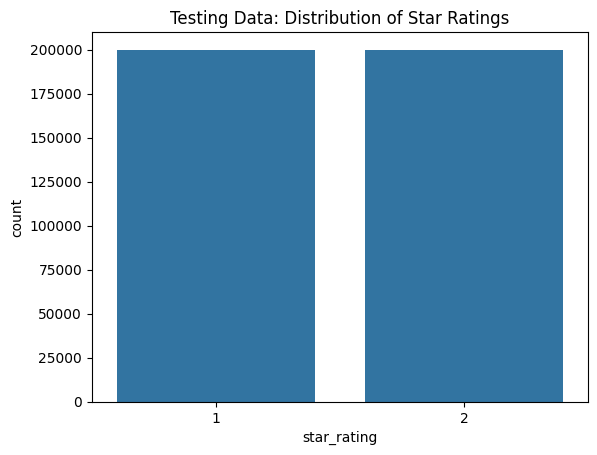

In [ ]:
# Visualize star rating distribution
sns.countplot(x='star_rating', data=train_data)
plt.title('Training Data: Distribution of Star Ratings')
plt.show()

sns.countplot(x='star_rating', data=test_data)
plt.title('Testing Data: Distribution of Star Ratings')
plt.show()


# Exploratory Data Analysis

1. Dataset overview- to dislay the basic statistics and a preview of the data

2. Visualize the distribution of the positive vs negative reviews based on the star ratings

3. Length analysis: Length of reviews in chars and words

4. Word frequency analysis: Identify the most common words in the positive and negative reviews

5. Visualize the most frequent words in the positive and negative reviews

6. Length compasrison; Check the ave. length between the positive and negative reviews

7.





In [ ]:
# Dataset overview
print("Training Data Overview:")
print(train_data.info())
print(train_data.describe())

# Preview first few rows
print("Sample Training Data:\n", train_data.head())

Training Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_body  object
 1   star_rating  int64 
dtypes: int64(1), object(1)
memory usage: 54.9+ MB
None
       star_rating
count    3600000.0
mean           1.5
std            0.5
min            1.0
25%            1.0
50%            1.5
75%            2.0
max            2.0
Sample Training Data:
                                          review_body  star_rating
0  Stuning even for the non-gamer: This sound tra...            2
1  The best soundtrack ever to anything.: I'm rea...            2
2  Amazing!: This soundtrack is my favorite music...            2
3  Excellent Soundtrack: I truly like this soundt...            2
4  Remember, Pull Your Jaw Off The Floor After He...            2


<ipython-input-10-2ab782d2221b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='star_rating', data=train_data, palette='viridis')


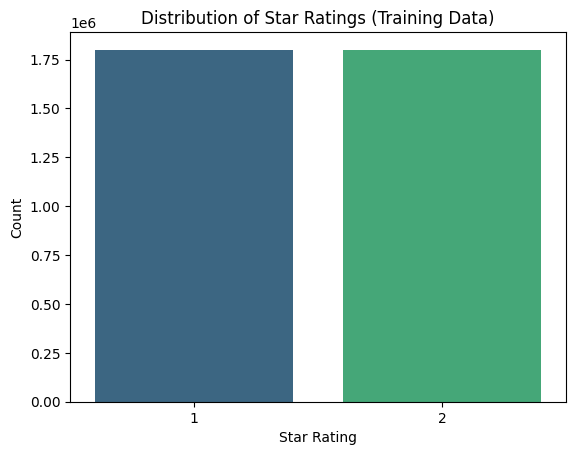

In [ ]:
# Plot distribution of star ratings
sns.countplot(x='star_rating', data=train_data, palette='viridis')
plt.title('Distribution of Star Ratings (Training Data)')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

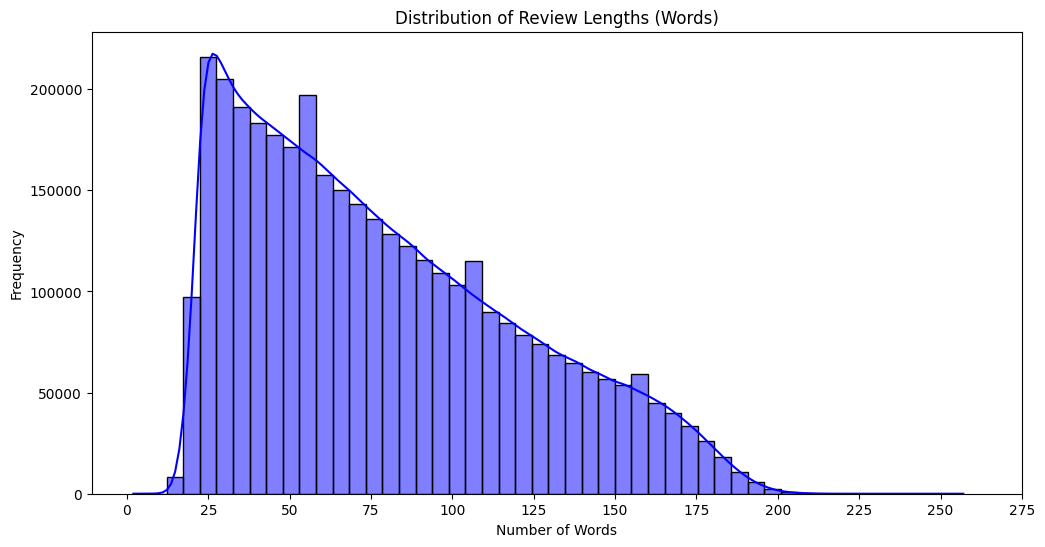

Review Length Statistics (Training Data):
       review_length_char  review_length_words
count        3.600000e+06         3.600000e+06
mean         4.316463e+02         7.848273e+01
std          2.375526e+02         4.283280e+01
min          7.200000e+01         2.000000e+00
25%          2.310000e+02         4.200000e+01
50%          3.830000e+02         7.000000e+01
75%          5.950000e+02         1.080000e+02
max          1.015000e+03         2.570000e+02


In [ ]:
# Review length analysis
# Add columns for review length (characters and words)
train_data['review_length_char'] = train_data['review_body'].apply(len)
train_data['review_length_words'] = train_data['review_body'].apply(lambda x: len(x.split()))

# Plot distribution of review lengths
plt.figure(figsize=(12, 6))
sns.histplot(train_data['review_length_words'], bins=50, kde=True, color='blue')
plt.title('Distribution of Review Lengths (Words)')
plt.xlabel('Number of Words')
plt.xticks(ticks=range(0, 300, 25))
plt.ylabel('Frequency')
plt.show()

# Summary statistics for review lengths
print("Review Length Statistics (Training Data):")
print(train_data[['review_length_char', 'review_length_words']].describe())


In [ ]:
# Frequent Words Analysis
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Define stopwords
stop_words = set(stopwords.words('english'))

# Tokenize reviews and remove stopwords
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalnum() and word not in stop_words]

# Define a subset of data (e.g., 100,000 reviews)
subset_data = train_data.sample(n=100000, random_state=42)

# Apply preprocessing
subset_data['tokens'] = subset_data['review_body'].apply(preprocess_text)

# Separate positive and negative reviews
positive_reviews = subset_data[subset_data['star_rating'] == 2]
negative_reviews = subset_data[subset_data['star_rating'] == 1]

# Get most common words
positive_words = Counter([word for tokens in positive_reviews['tokens'] for word in tokens])
negative_words = Counter([word for tokens in negative_reviews['tokens'] for word in tokens])

# Display top 10 words
print("Most Common Words in Positive Reviews:", positive_words.most_common(10))
print("Most Common Words in Negative Reviews:", negative_words.most_common(10))


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Most Common Words in Positive Reviews: [('book', 27723), ('great', 23152), ('one', 18000), ('good', 16638), ('like', 13232), ('read', 10925), ('love', 9968), ('would', 9334), ('well', 8890), ('best', 8563)]
Most Common Words in Negative Reviews: [('book', 25767), ('one', 19112), ('would', 16050), ('like', 14870), ('good', 11918), ('get', 10940), ('time', 9924), ('even', 8905), ('movie', 8857), ('read', 8259)]


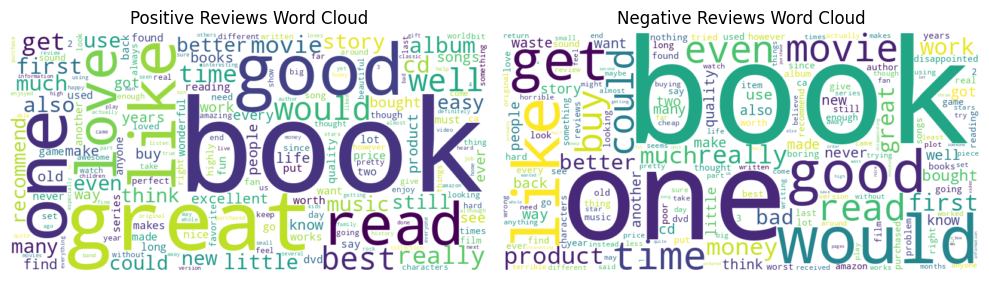

In [ ]:
# Visualizing Most Common Words in Positive and Negative Reviews
from wordcloud import WordCloud

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_words)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_words)

# Plot word clouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Compare average review lengths
avg_length_positive = positive_reviews['review_length_words'].mean()
avg_length_negative = negative_reviews['review_length_words'].mean()

print(f"Average Length of Positive Reviews: {avg_length_positive:.2f} words")
print(f"Average Length of Negative Reviews: {avg_length_negative:.2f} words")


Average Length of Positive Reviews: 75.37 words
Average Length of Negative Reviews: 81.46 words


**Unigrams, Bigrams, Trigrams**

In [ ]:
import pandas as pd

# Reload the original training data
train_data = pd.read_csv('/content/drive/MyDrive/AmazonReviewsData/train.ft.txt', sep='\t', names=['review_body', 'star_rating'])

# Sample a smaller subset of data to avoid memory issues
subset_data = train_data.sample(n=100000, random_state=42)

# Ensure the sampled subset exists
print("Subset Data Shape:", subset_data.shape)


Subset Data Shape: (100000, 2)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Reduce dataset size
# subset_data = train_data.sample(n=100000, random_state=42)

# Create vectorizer with optimized parameters
vectorizer = CountVectorizer(
    ngram_range=(1, 3),  # Generate unigrams, bigrams, and trigrams
    stop_words='english',
    max_features=5000,  # Limit the number of n-grams
    min_df=5  # Ignore n-grams that appear in fewer than 5 documents
)

# Fit and transform
X_ngrams = vectorizer.fit_transform(subset_data['review_body'])

# Display shape
print("Shape of Sparse Matrix:", X_ngrams.shape)

# Retrieve top n-grams
top_ngrams = X_ngrams.sum(axis=0).A1  # Efficient sum for sparse matrix
features = vectorizer.get_feature_names_out()
top_ngrams_df = pd.DataFrame({'ngram': features, 'count': top_ngrams}).sort_values(by='count', ascending=False).head(10)
print("Top 10 N-grams:\n", top_ngrams_df)



Shape of Sparse Matrix: (100000, 5000)
Top 10 N-grams:
            ngram  count
586         book  54191
75    __label__1  50013
136   __label__2  49987
2036       great  30221
1976        good  28991
2646        like  28455
2479        just  26468
3587        read  19664
4493        time  18832
2997       movie  16849


In [ ]:
# Stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')  # Ensure the tokenizer is available

# Initialize the stemmer
stemmer = PorterStemmer()

# Define a stemming function
def stem_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    return " ".join([stemmer.stem(word) for word in tokens if word.isalnum()])  # Stem each word and remove non-alphanumeric

# Apply stemming to a sample subset of reviews
subset_data['stemmed_review'] = subset_data['review_body'].apply(stem_text)

# Display a few examples before and after stemming
print("Original Review:\n", subset_data['review_body'].iloc[0])
print("Stemmed Review:\n", subset_data['stemmed_review'].iloc[0])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Original Review:
 __label__1 Expensive Junk: This product consists of a piece of thin flexible insulating material, adhesive backed velcro and white electrical tape.Problems:1. Instructions are three pictures with little more information.2. Velcro was all crumpled as received and was stronger than the adhesive. When i tried to disengage the velcro both pieces came off and the paint from the ceiling.3. White electrical tape was horrible... cheap, narrow and it fell off in less than 1 hour.4. The price is a ripoff.I am building my own which is easier to use, cheaper, more attractive, and higher r-value. I am surprised Amazon even lists this junk.
Stemmed Review:
 expens junk thi product consist of a piec of thin flexibl insul materi adhes back velcro and white electr instruct are three pictur with littl more velcro wa all crumpl as receiv and wa stronger than the adhes when i tri to disengag the velcro both piec came off and the paint from the white electr tape wa horribl cheap narrow an

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import nltk
nltk.download('averaged_perceptron_tagger_eng')

# Download required resources
nltk.download('wordnet')
nltk.download('omw-1.4')  # For WordNet lemmatizer
nltk.download('averaged_perceptron_tagger')  # For POS tagging
nltk.download('punkt')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Map POS tag to WordNet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Lemmatize a review
def lemmatize_review(review):
    tokens = word_tokenize(review.lower())
    pos_tags = nltk.pos_tag(tokens)  # Get part-of-speech tags
    return ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags])

# Apply lemmatization to the subset
subset_data['lemmatized_review'] = subset_data['review_body'].apply(lemmatize_review)

# Display an example
example_review = subset_data['review_body'].iloc[0]
lemmatized_example = subset_data['lemmatized_review'].iloc[0]

print("Original Review:\n", example_review)
print("\nLemmatized Review:\n", lemmatized_example)


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


KeyboardInterrupt: 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Original Review:
 __label__1 Expensive Junk: This product consists of a piece of thin flexible insulating material, adhesive backed velcro and white electrical tape.Problems:1. Instructions are three pictures with little more information.2. Velcro was all crumpled as received and was stronger than the adhesive. When i tried to disengage the velcro both pieces came off and the paint from the ceiling.3. White electrical tape was horrible... cheap, narrow and it fell off in less than 1 hour.4. The price is a ripoff.I am building my own which is easier to use, cheaper, more attractive, and higher r-value. I am surprised Amazon even lists this junk.

Lemmatized Review:
 __label__1 expensive junk : this product consist of a piece of thin flexible insulate material , adhesive back velcro and white electrical tape.problems:1. instruction be three picture with little more information.2 . velcro be all crumple a received and be strong than the adhesive . when i try to disengage the velcro both p